# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore")

# Dataset reading

In [2]:
df=pd.read_csv("smoke_detection_iot.csv")
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [3]:
df.shape

(62630, 16)

In [4]:
df.isnull().sum()

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

In [5]:
duplicate = df[df.duplicated()]
duplicate.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm


In [6]:
df['Fire Alarm'].value_counts()

1    44757
0    17873
Name: Fire Alarm, dtype: int64

In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace= True)

In [8]:
df.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


# EDA

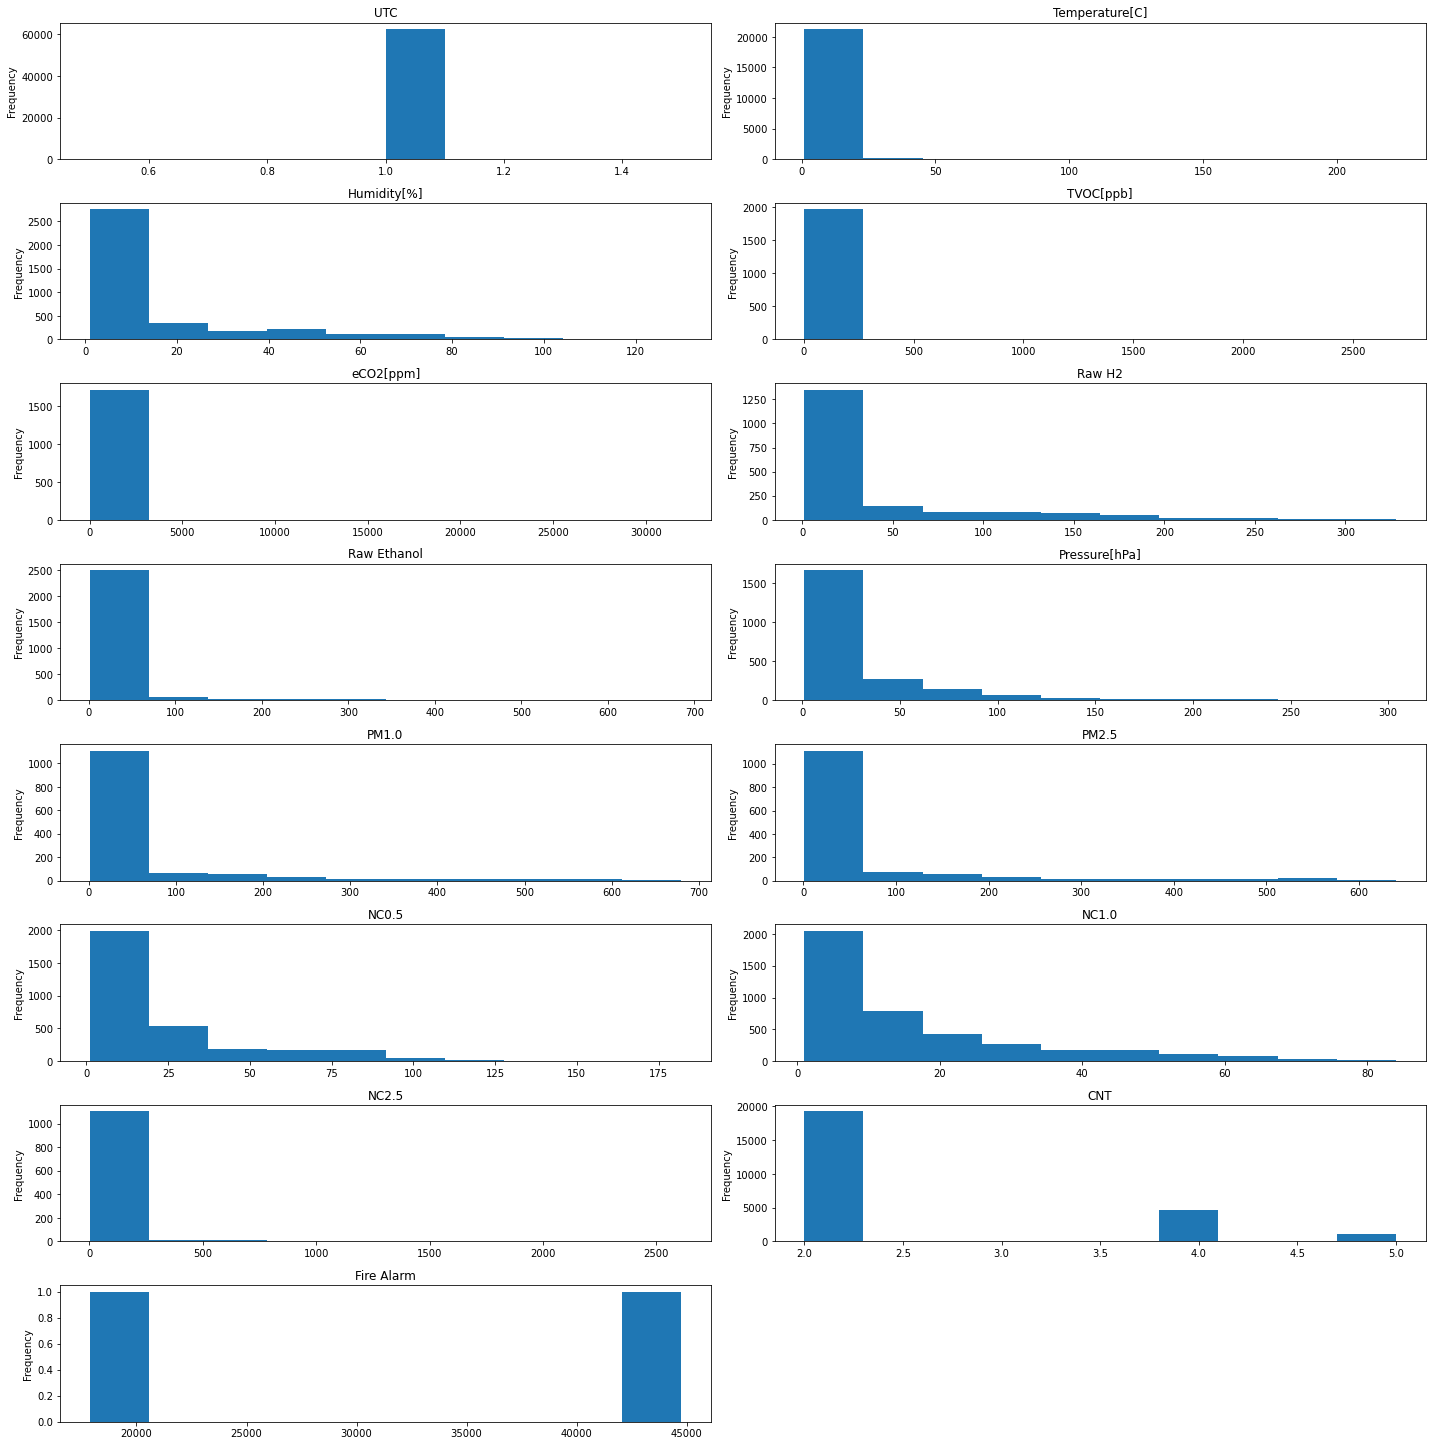

In [9]:
j =1
fig = plt.figure(figsize = (20,40))
for i in df.columns: 
    plt.subplot(16,2,j)
    df[i].value_counts().plot(kind ='hist')
    j=j+1
    plt.title(i)
plt.tight_layout()

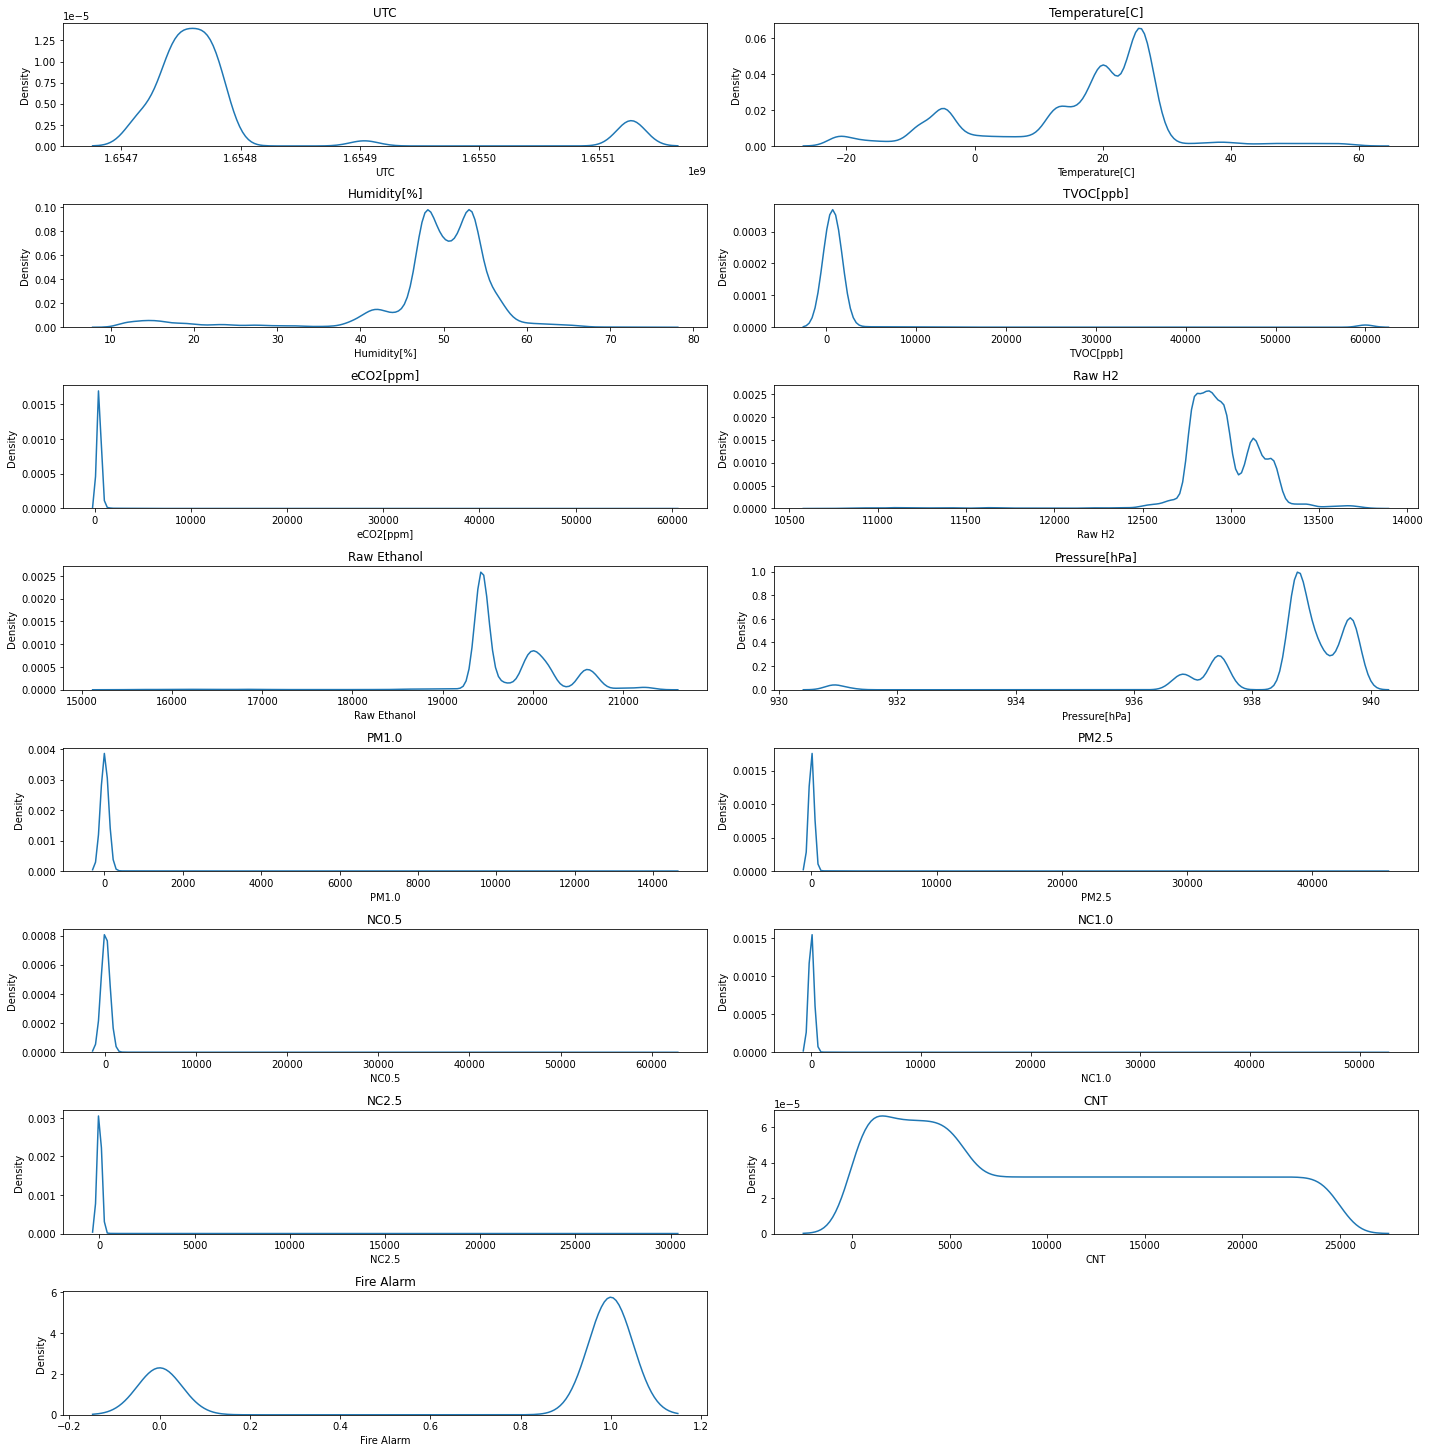

In [10]:
j =1
fig = plt.figure(figsize = (20,40))
for i in df.columns:
    
    plt.subplot(16,2,j)
    sns.distplot(df[i],hist = False)
    j = j+1
    plt.title(i)
plt.tight_layout()


# Observation

* It is clear that the majority of the fields are skewed from the above histogram and distplots. Since the data is skewed, our dataset contains outliers. Let's depict that utilising Boxplots.

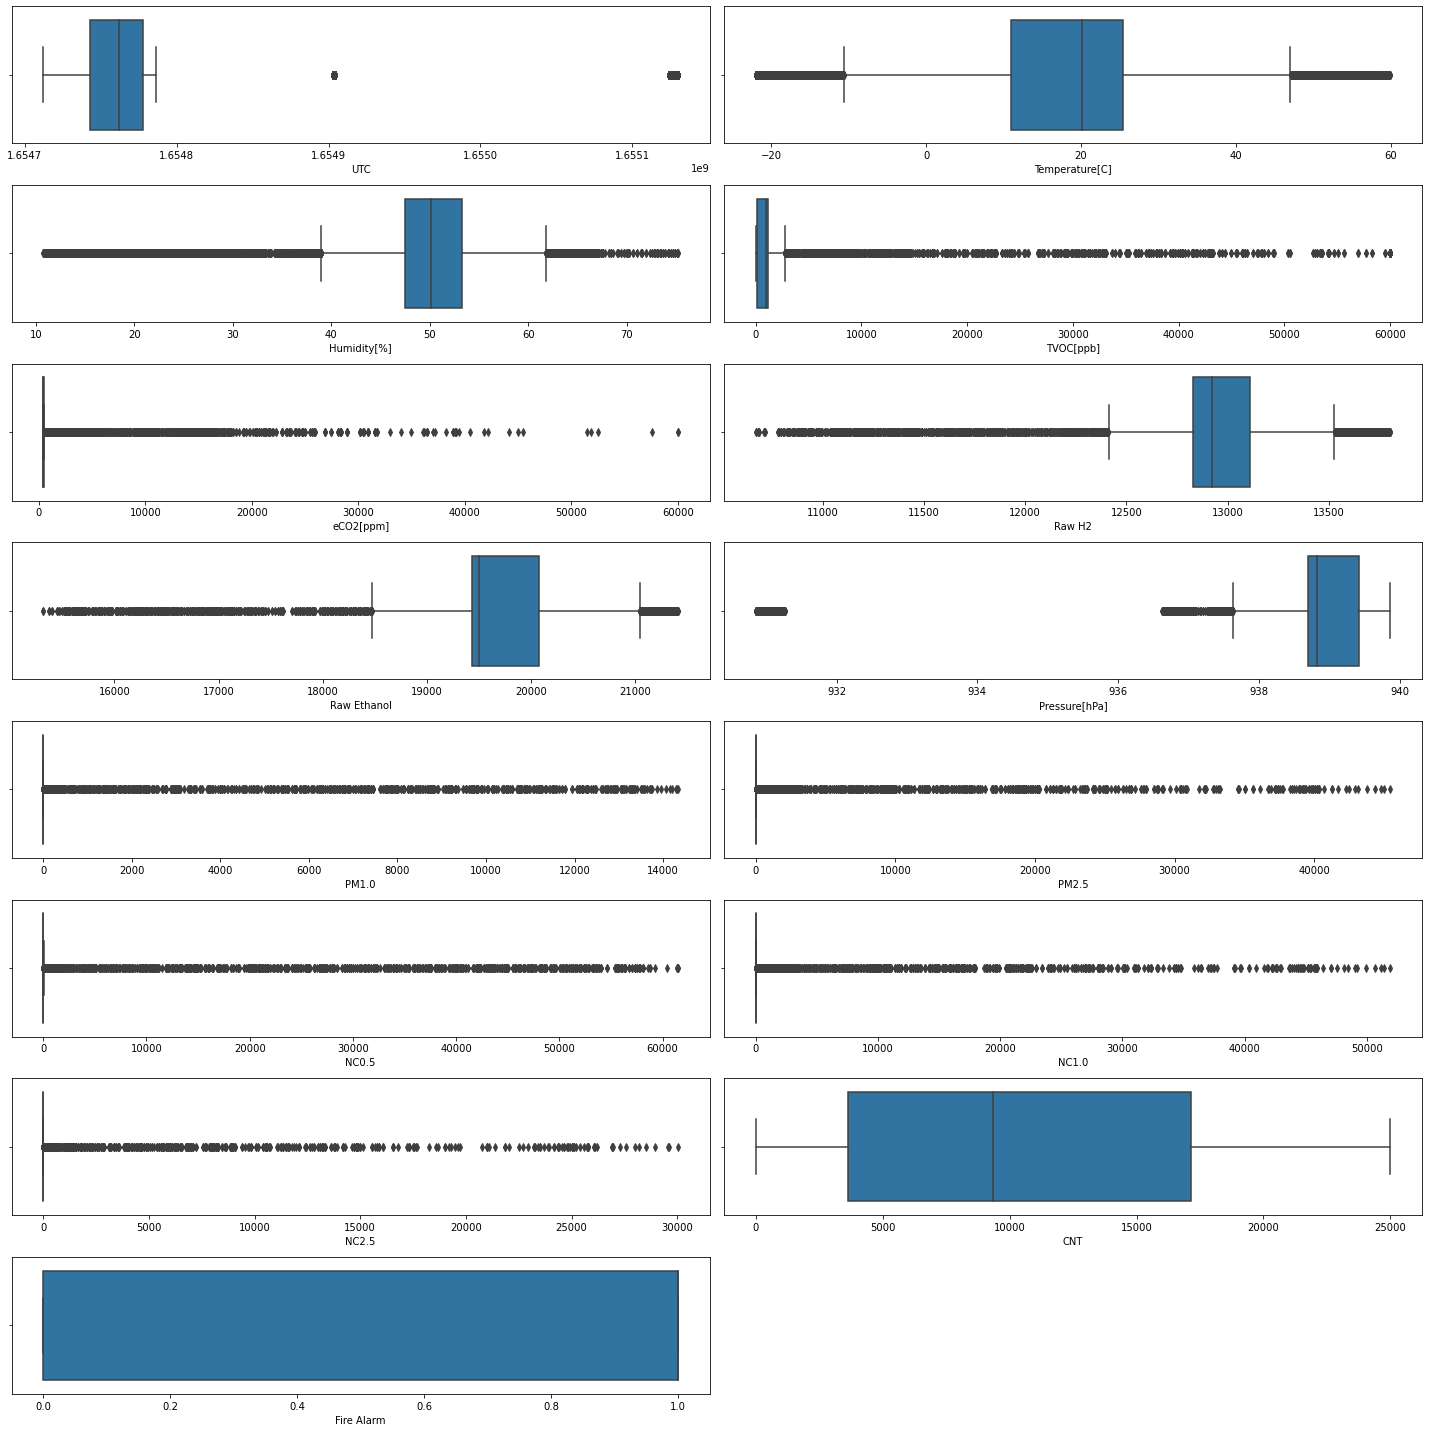

In [11]:
j =1
plt.figure(figsize = (20,20))
for i in df.columns:
    plt.subplot(8,2,j)
    sns.boxplot(df[i])
    j=j+1
plt.tight_layout()

# Observations

* We may conclude from the box plot that the outliers can be found just outside of the IQR. They can just be seen clearly near the lower and upper levels of IQR.

* In another way, by calculating the mean and median, we can more precisely confirm the existence of outliers. We may claim that there are very little possibilities of seeing an outlier if both the values are nearly identical.

In [12]:
Fire = df[df['Fire Alarm']==1]

No_fire = df[df['Fire Alarm']==0]

In [13]:
Fire

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
3178,1654736509,9.381,56.86,11,400,13347,20160,939.575,1.78,1.85,12.25,1.911,0.043,3178,1
3179,1654736510,9.368,58.60,0,400,13385,20202,939.574,1.80,1.87,12.41,1.935,0.044,3179,1
3180,1654736511,9.356,60.38,0,400,13388,20248,938.858,1.94,2.01,13.32,2.077,0.047,3180,1
3181,1654736512,9.343,62.22,0,400,13443,20315,939.044,2.00,2.08,13.75,2.145,0.048,3181,1
3182,1654736513,9.331,63.11,0,400,13457,20348,939.193,2.07,2.15,14.24,2.220,0.050,3182,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51141,1654904158,31.120,18.67,0,873,13077,20927,930.929,1.00,1.04,6.89,1.075,0.024,1153,1
51145,1654712190,27.320,43.84,29,454,12858,20752,937.610,2.24,2.32,15.39,2.400,0.054,3,1
51146,1654712191,27.270,43.98,28,456,12860,20751,937.601,2.26,2.35,15.58,2.429,0.055,4,1
56889,1655124311,20.191,43.84,29,454,12858,20752,937.610,2.24,2.32,15.39,2.400,0.054,3,1


In [14]:
No_fire

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


<AxesSubplot:ylabel='Fire Alarm'>

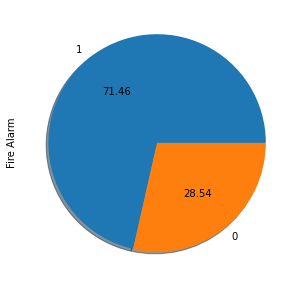

In [15]:
fig = plt.figure(figsize = (15,5))

df['Fire Alarm'].value_counts().plot(kind ='pie',autopct = '%.2f', shadow=True)

# 1. UTC

In [16]:
# Mean
print ("Mean :")
print((np.mean(Fire['UTC'])),"when there is fire")
print((np.mean(No_fire['UTC'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['UTC'])),"when there is fire")
print((np.median(No_fire['UTC'])),"when there is no fire")

Mean :
1654764997.4949617 when there is fire
1654859850.7379286 when there is no fire
Median :
1654765081.0 when there is fire
1654761359.0 when there is no fire


# 2. Temperature 

In [17]:
# Mean
print ("Mean :")
print((np.mean(Fire['Temperature[C]'])),"when there is fire")
print((np.mean(No_fire['Temperature[C]'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['Temperature[C]'])),"when there is fire")
print((np.median(No_fire['Temperature[C]'])),"when there is no fire")

Mean :
14.483151551712472 when there is fire
19.694803054887505 when there is no fire
Median :
20.02 when there is fire
20.54 when there is no fire


# 3. Humidity[%]


In [18]:
# Mean
print ("Mean :")
print((np.mean(Fire['Humidity[%]'])),"when there is fire")
print((np.mean(No_fire['Humidity[%]'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['Humidity[%]'])),"when there is fire")
print((np.median(No_fire['Humidity[%]'])),"when there is no fire")

Mean :
50.77953370422544 when there is fire
42.93007665193305 when there is no fire
Median :
51.4 when there is fire
46.14 when there is no fire


# 4. TVOC[ppb]

In [19]:
# Mean
print ("Mean :")
print((np.mean(Fire['TVOC[ppb]'])),"when there is fire")
print((np.mean(No_fire['TVOC[ppb]'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['TVOC[ppb]'])),"when there is fire")
print((np.median(No_fire['TVOC[ppb]'])),"when there is no fire")

Mean :
882.0130705811381 when there is fire
4596.587254517988 when there is no fire
Median :
1103.0 when there is fire
86.0 when there is no fire


# 5. eCO2[ppm]

In [20]:
# Mean
print ("Mean :")
print((np.mean(Fire['eCO2[ppm]'])),"when there is fire")
print((np.mean(No_fire['eCO2[ppm]'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['eCO2[ppm]'])),"when there is fire")
print((np.median(No_fire['eCO2[ppm]'])),"when there is no fire")

Mean :
553.18935585495 when there is fire
962.5872545179881 when there is no fire
Median :
404.0 when there is fire
400.0 when there is no fire


# 6. Raw H2

In [21]:
# Mean
print ("Mean :")
print((np.mean(Fire['Raw H2'])),"when there is fire")
print((np.mean(No_fire['Raw H2'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['Raw H2'])),"when there is fire")
print((np.median(No_fire['Raw H2'])),"when there is no fire")

Mean :
12960.878052595124 when there is fire
12896.316846640184 when there is no fire
Median :
12933.0 when there is fire
12837.0 when there is no fire


# 7. Raw Ethanol

In [22]:
# Mean
print ("Mean :")
print((np.mean(Fire['Raw Ethanol'])),"when there is fire")
print((np.mean(No_fire['Raw Ethanol'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['Raw Ethanol'])),"when there is fire")
print((np.median(No_fire['Raw Ethanol'])),"when there is no fire")

Mean :
19623.050427866034 when there is fire
20082.82353270296 when there is no fire
Median :
19454.0 when there is fire
20158.0 when there is no fire


# 8. Pressure[hPa]

In [23]:
# Mean
print ("Mean :")
print((np.mean(Fire['Pressure[hPa]'])),"when there is fire")
print((np.mean(No_fire['Pressure[hPa]'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['Pressure[hPa]'])),"when there is fire")
print((np.median(No_fire['Pressure[hPa]'])),"when there is no fire")

Mean :
938.8378055723172 when there is fire
938.1013832037153 when there is no fire
Median :
938.878 when there is fire
937.478 when there is no fire


# 9. PM1.0

In [24]:
# Mean
print ("Mean :")
print((np.mean(Fire['PM1.0'])),"when there is fire")
print((np.mean(No_fire['PM1.0'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['PM1.0'])),"when there is fire")
print((np.median(No_fire['PM1.0'])),"when there is no fire")

Mean :
36.14640570190133 when there is fire
261.9827057572892 when there is no fire
Median :
1.87 when there is fire
1.45 when there is no fire


# 10. PM2.5

In [25]:
# Mean
print ("Mean :")
print((np.mean(Fire['PM2.5'])),"when there is fire")
print((np.mean(No_fire['PM2.5'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['PM2.5'])),"when there is fire")
print((np.median(No_fire['PM2.5'])),"when there is no fire")

Mean :
78.41784190182555 when there is fire
450.03463884070914 when there is no fire
Median :
1.94 when there is fire
1.52 when there is no fire


# 11. NC0.5

In [26]:
# Mean
print ("Mean :")
print((np.mean(Fire['NC0.5'])),"when there is fire")
print((np.mean(No_fire['NC0.5'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['NC0.5'])),"when there is fire")
print((np.median(No_fire['NC0.5'])),"when there is no fire")

Mean :
146.11133699756448 when there is fire
1356.28381581156 when there is no fire
Median :
12.86 when there is fire
9.97 when there is no fire


# 12. NC1.0

In [27]:
# Mean
print ("Mean :")
print((np.mean(Fire['NC1.0'])),"when there is fire")
print((np.mean(No_fire['NC1.0'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['NC1.0'])),"when there is fire")
print((np.median(No_fire['NC1.0'])),"when there is no fire")

Mean :
87.66554912080782 when there is fire
493.8720265204505 when there is no fire
Median :
2.005 when there is fire
1.578 when there is no fire


# 13. NC2.5

In [28]:
# Mean
print ("Mean :")
print((np.mean(Fire['NC2.5'])),"when there is fire")
print((np.mean(No_fire['NC2.5'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['NC2.5'])),"when there is fire")
print((np.median(No_fire['NC2.5'])),"when there is no fire")

Mean :
40.54162723149459 when there is fire
178.982258770214 when there is no fire
Median :
0.045 when there is fire
0.039 when there is no fire


# 14. CNT

In [29]:
# Mean
print ("Mean :")
print((np.mean(Fire['CNT'])),"when there is fire")
print((np.mean(No_fire['CNT'])),"when there is no fire")
# Median
print ("Median :")
print((np.median(Fire['CNT'])),"when there is fire")
print((np.median(No_fire['CNT'])),"when there is no fire")

Mean :
13746.30343856827 when there is fire
2410.60885134001 when there is no fire
Median :
13804.0 when there is fire
2226.0 when there is no fire


In [30]:
from prettytable import PrettyTable
myTable = PrettyTable(["FEATURES", "MEAN (Fire)","MEDIAN (Fire)","MEAN (No_Fire)","MEDIAN (No_Fire)"])
myTable.add_rows([["UTC", "1654764997.49", "1654765081.0", "1654859850.73", "1654761359.0"], 
                  [" Temperature[C]"," 14.48","20.02", "19.69", "20.54"],
                  ["Humidity[%]","50.77","51.4", "42.93","46.14"], 
                  ["TVOC[ppb]","882.01","1103.0", "4596.58","86.0"], 
                  ["eCO2[ppm]","553.18","404.0", "962.58","400.0"],
                  ["Raw H2","12960.87","12933.0", "12896.31","12837.0"],
                  ["Raw Ethanol","19623.05","19454.0", "20082.82","20158.0"],
                  ["Pressure[hPa]","938.83","938.87", "938.10","937.47"],
                  ["PM1.0","36.14","1.87", "261.98","1.45"],
                  ["PM2.5","78.41","1.94", "450.03","1.52"],
                  ["NC0.5","146.11","12.86", "1356.28","9.97"],
                  ["NC1.0","553.18","404.0", "962.58","400.0"],
                  ["NC2.5","87.66","2.0", "493.87","1.57"],
                  ["CNT","13746.30","13804.0", "2410.60","2226.0"]])


print(myTable)

+-----------------+---------------+---------------+----------------+------------------+
|     FEATURES    |  MEAN (Fire)  | MEDIAN (Fire) | MEAN (No_Fire) | MEDIAN (No_Fire) |
+-----------------+---------------+---------------+----------------+------------------+
|       UTC       | 1654764997.49 |  1654765081.0 | 1654859850.73  |   1654761359.0   |
|  Temperature[C] |      14.48    |     20.02     |     19.69      |      20.54       |
|   Humidity[%]   |     50.77     |      51.4     |     42.93      |      46.14       |
|    TVOC[ppb]    |     882.01    |     1103.0    |    4596.58     |       86.0       |
|    eCO2[ppm]    |     553.18    |     404.0     |     962.58     |      400.0       |
|      Raw H2     |    12960.87   |    12933.0    |    12896.31    |     12837.0      |
|   Raw Ethanol   |    19623.05   |    19454.0    |    20082.82    |     20158.0      |
|  Pressure[hPa]  |     938.83    |     938.87    |     938.10     |      937.47      |
|      PM1.0      |     36.14   

# Observation

* Features such as 'UTC,' 'Raw H2,' 'Raw Ethanol,' 'Pressure,' 'Humidity,' and 'CNT' exhibit nearly identical mean and median values for both Fire and No fire, indicating that there are very few outliers.

* However, features such as 'Temperature,' 'TVOC,' 'eCO2,' 'PM1.0,' 'PM2.5,' 'NC0.5,' 'NC1.0,' and 'NC2.5' possess extremely varying mean and median values, showing that these features contain lots of outliers.

# Correlation Matrix

In [31]:
corr = df.corr()
plt.figure(figsize=(10,10))
corr.style.background_gradient(cmap='coolwarm')

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
UTC,1.000000,-0.164174,-0.391907,0.180731,0.132100,-0.151088,0.166555,-0.434375,0.123168,0.105304,0.130288,0.103695,0.083234,-0.251595,-0.389404
Temperature[C],-0.164174,1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.089850,-0.163902
Humidity[%],-0.391907,-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.251965,0.399846
TVOC[ppb],0.180731,0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.057703,-0.214743
eCO2[ppm],0.132100,0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.106681,-0.097006
Raw H2,-0.151088,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,-0.031036,0.107007
Raw Ethanol,0.166555,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.511995,-0.340652
Pressure[hPa],-0.434375,-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.186290,0.249797
PM1.0,0.123168,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.093700,-0.110552
PM2.5,0.105304,0.032084,-0.178882,0.477424,0.572691,-0.431079,-0.393192,-0.243071,0.956118,1.000000,0.798873,0.999787,0.969382,-0.083869,-0.084916


<Figure size 720x720 with 0 Axes>

# Observation

* The correlation heatmap reveals that while features 'PM' and 'CM' have the highest correlation with one another, they also do not significantly contribute to the target variable.
* Also, features 'CNT' and 'Humidity' contributes comparatively higher to target variable than the other features.

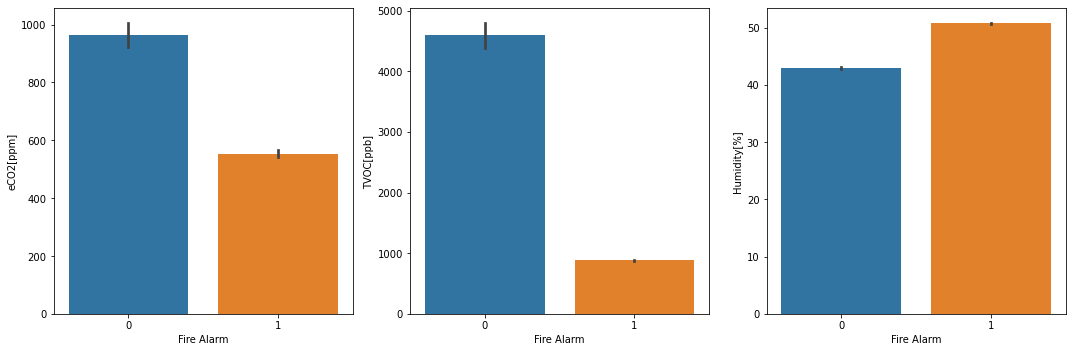

In [32]:
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
sns.barplot(df['Fire Alarm'] , df['eCO2[ppm]'])
plt.subplot(132)
sns.barplot(df['Fire Alarm'] , df['TVOC[ppb]'])
plt.subplot(133)
sns.barplot(df['Fire Alarm'] , df['Humidity[%]'])
plt.tight_layout()

* There is a probability that the fire alarm will trigger when the level of 'eCO2' (equivalent carbon dioxide) drops.
* The same applies to 'TVOC'(total volatile organic compounds); if it drops, a fire alarm will trigger.
* As contrary to previous observations, the File Alarm will activate with a slight increase in "Humidity%." This justification is valid since a fire's smoke will raise the air's humidity level.

<AxesSubplot:xlabel='Fire Alarm', ylabel='PM2.5'>

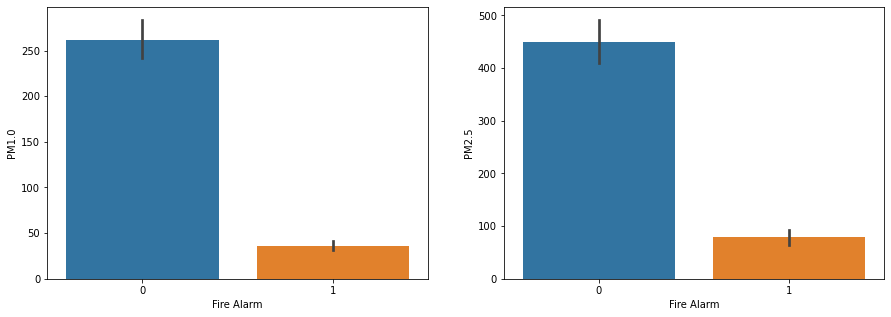

In [33]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(df['Fire Alarm'] , df['PM1.0'])
plt.subplot(122)
sns.barplot(df['Fire Alarm'] , df['PM2.5'])

* From the plot above, we notice that the smoke alarm will activate when the size of smoke particulate matters (PM1.0 and PM2.5) decreases.

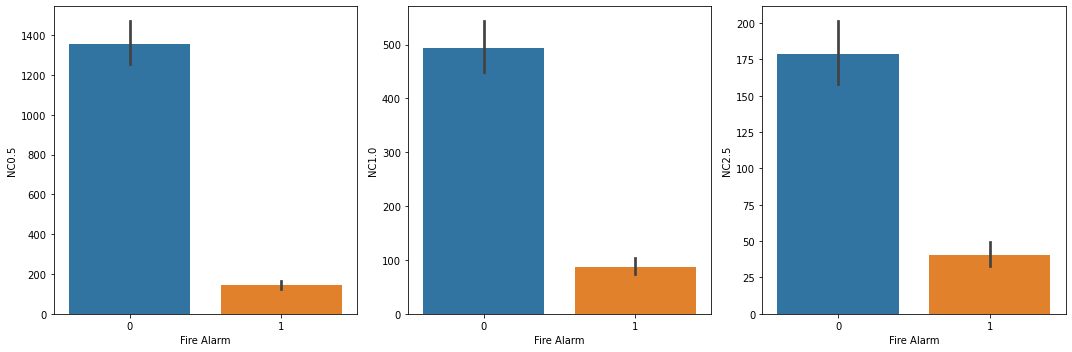

In [34]:
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
sns.barplot(df['Fire Alarm'] , df['NC0.5'])
plt.subplot(132)
sns.barplot(df['Fire Alarm'] , df['NC1.0'])
plt.subplot(133)
sns.barplot(df['Fire Alarm'] , df['NC2.5'])
plt.tight_layout()

* It is obvious that a drop in the number of particulate matter (NC0.5, NC1.0 and NC2.5) will cause the smoke alarm to trigger.

# Training & Testing data

In [35]:
X=df.iloc[:,0:14]

In [36]:
X.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4


In [37]:
y=df.iloc[:,14:]

In [38]:
y.head()

,Fire Alarm
0,0
1,0
2,0
3,0
4,0


In [39]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [40]:
X_train.shape

(50104, 14)

In [41]:
y_train.shape

(50104, 1)

In [42]:
X_test.shape

(12526, 14)

In [43]:
y_test.shape

(12526, 1)

# Feature Scaling

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modelling

# 1. K-NN Algorithm

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

hyper_parameter_k=[{'n_neighbors':[11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]}]
clf= KNeighborsClassifier()
modelknn=GridSearchCV( clf,hyper_parameter_k,scoring='accuracy')

modelknn.fit(X_train,y_train)

print(modelknn.best_estimator_)
print("training accuracy is",modelknn.score(X_train,y_train))
print("testing accuracy is ",modelknn.score(X_test,y_test))

KNeighborsClassifier(n_neighbors=15)
training accuracy is 0.9993812869231997
testing accuracy is  0.9996806642184257


In [46]:
#PREDICTIONS
knn_test_prediction=modelknn.predict(X_test)
knn_train_predictions=modelknn.predict(X_train)

In [47]:
# confusion matrix
#testing confusion matrix
from sklearn.metrics import confusion_matrix
x_knn_cf_test=confusion_matrix(y_test,knn_test_prediction)
print(x_knn_cf_test)

[[3592    2]
 [   2 8930]]


Test confusion matrix


<AxesSubplot:>

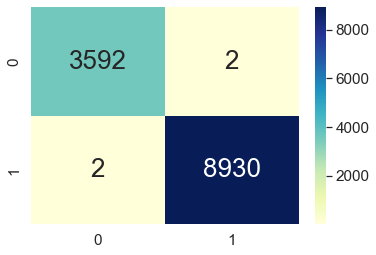

In [48]:
print("Test confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_knn_cf_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [49]:
# confusion matrix
#training confusion matrix
from sklearn.metrics import confusion_matrix
x_knn_cf_train=confusion_matrix(y_train,knn_train_predictions)
print(x_knn_cf_train)

[[14260    19]
 [   12 35813]]


Train confusion matrix


<AxesSubplot:>

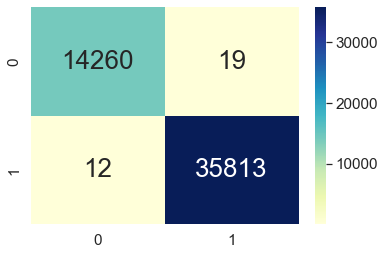

In [50]:
print("Train confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_knn_cf_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [107]:
#F1 score
#Testing data
from sklearn.metrics import f1_score
X_knntest_F1score=f1_score(y_test,knn_test_prediction)
print("Testing F1 score for KNN is: ",X_knntest_F1score) 

#Training data
X_knntrain_F1score=f1_score(y_train,knn_train_predictions)
print("Training F1 score for KNN is: ",X_knntrain_F1score) 

Testing F1 score for KNN is:  0.9997760859829825
Training F1 score for KNN is:  0.9995673835075429


In [108]:
#Precision
#Testing data
from sklearn.metrics import precision_score
x_knn_p_test=precision_score(y_test,knn_test_prediction)
print("The precision of KNN for testing data is: ",x_knn_p_test)

#Training data
from sklearn.metrics import precision_score
x_knn_p=precision_score(y_train,knn_train_predictions)
print("The precision of KNN for training data is:",x_knn_p)

The precision of KNN for testing data is:  0.9997760859829825
The precision of KNN for training data is: 0.9994697477115427


In [109]:
#Recall
#Testing data
from sklearn.metrics import recall_score
x_knn_r_test=recall_score(y_test,knn_test_prediction)
print("The recall of test data for knn is: ",x_knn_r_test)

#Training data
from sklearn.metrics import recall_score
x_knn_r_train=recall_score(y_train,knn_train_predictions)
print("The recall of training data for knn is: ",x_knn_r_train)

The recall of test data for knn is:  0.9997760859829825
The recall of training data for knn is:  0.9996650383810188


In [110]:
#Accuracy
#Training data
from sklearn.metrics import accuracy_score
a=accuracy_score(y_train,knn_train_predictions)

print("training accuracy for KNN is:",a)

#Tesing data
from sklearn.metrics import accuracy_score
b=accuracy_score(y_test,knn_test_prediction)

print("testing accuracy for KNN is:",b)

training accuracy for KNN is: 0.9993812869231997
testing accuracy for KNN is: 0.9996806642184257


# 2. Logistic Regression

In [55]:
tuned_parameters=[{'C':[10**-8,10**-4,10**0,10**4,10**8]}]

LRmodel=GridSearchCV(LogisticRegression(max_iter=400,class_weight='balanced'),tuned_parameters)

LRmodel.fit(X_train,y_train)

print(LRmodel.best_estimator_)
print(LRmodel.score(X_test,y_test))
print(LRmodel.score(X_train,y_train))

LogisticRegression(C=10000, class_weight='balanced', max_iter=400)
0.9935334504231199
0.9923558997285646


In [56]:
#PREDICTIONS
LR_test_prediction=LRmodel.predict(X_test)
LR_train_prediction=LRmodel.predict(X_train)

In [57]:
# confusion matrix
#testing confusion matrix
from sklearn.metrics import confusion_matrix
x_LR_cf_test=confusion_matrix(y_test,LR_test_prediction)
print(x_LR_cf_test)

[[3586    8]
 [  73 8859]]


Test confusion matrix


<AxesSubplot:>

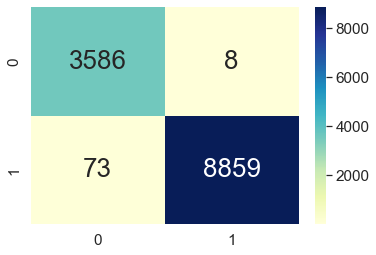

In [58]:
print("Test confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_LR_cf_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [59]:
# confusion matrix
#training confusion matrix
from sklearn.metrics import confusion_matrix
x_LR_cf_train=confusion_matrix(y_train,LR_train_prediction)
print(x_LR_cf_train)

[[14238    41]
 [  342 35483]]


Train confusion matrix


<AxesSubplot:>

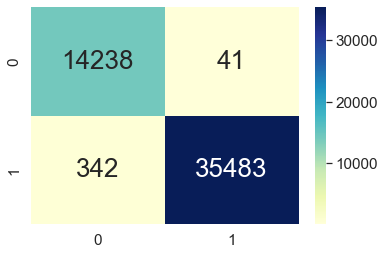

In [60]:
print("Train confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_LR_cf_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [111]:
#F1 score
#Testing data
from sklearn.metrics import f1_score
X_LR_test_F1score=f1_score(y_test,LR_test_prediction)
print("Testing F1 score for Logistic Regression is:",X_LR_test_F1score) 

#Training data
X_LR_train_F1score=f1_score(y_train,LR_train_prediction)
print("Training F1 score for Logistic Regression is:",X_LR_train_F1score)

Testing F1 score for Logistic Regression is: 0.9954491825383447
Training F1 score for Logistic Regression is: 0.9946320200703583


In [112]:
#Precision
#Testing data
from sklearn.metrics import precision_score
X_LR_prec_test=precision_score(y_test,LR_test_prediction)
print("The precision of Logistic Regression for testing data is:",X_LR_prec_test)

#Training data
from sklearn.metrics import precision_score
X_LR_prec_train=precision_score(y_train,LR_train_prediction)
print("The precision of Logistic Regression for training data is:",X_LR_prec_train)

The precision of Logistic Regression for testing data is: 0.999097778279012
The precision of Logistic Regression for training data is: 0.9988458506924895


In [91]:
#Recall
#Testing data
from sklearn.metrics import recall_score
x_LR_rec_test=recall_score(y_test,LR_test_prediction)
print("The recall of test data for Logistic Regression is",x_LR_rec_test)

#Training data
from sklearn.metrics import recall_score
x_LR_rec_train=recall_score(y_train,LR_train_prediction)
print("The recall of training data for Logistic Regression is",x_LR_rec_train)

The recall of test data for Logistic Regression is 0.9918271383788625
The recall of training data for Logistic Regression is 0.990453593859037


In [113]:
#Accuracy
#Training data
from sklearn.metrics import accuracy_score
a=accuracy_score(y_train,LR_train_prediction)

print("training accuracy for Logistic Regression is",a)

#Testing data
from sklearn.metrics import accuracy_score
b=accuracy_score(y_test,LR_test_prediction)

print("testing accuracy for Logistic Regression is",b)

training accuracy for Logistic Regression is 0.9923558997285646
testing accuracy for Logistic Regression is 0.9935334504231199


# 3. Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200,300, 500],
    'max_depth' : [4,5,6]
}
rfc=RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

In [69]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 5, 'n_estimators': 300}


In [70]:
#training the random forest model
rfc_new=RandomForestClassifier(criterion= 'entropy', max_depth= 6, max_features= 'auto', n_estimators=500,random_state=42)
random_forest_model=rfc_new.fit(X_train,y_train)

In [71]:
#predictions
rf_predictions_test=random_forest_model.predict(X_test)
rf_predictions_train=random_forest_model.predict(X_train)

In [72]:
# confusion matrix
#training confusion matrix
from sklearn.metrics import confusion_matrix
x_rf_train=confusion_matrix(y_train,rf_predictions_train)
print(x_rf_train)

[[14279     0]
 [    2 35823]]


Train confusion matrix


<AxesSubplot:>

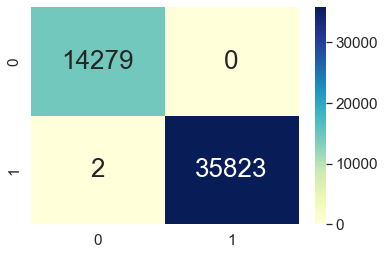

In [73]:
print("Train confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_rf_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [74]:
from sklearn.metrics import confusion_matrix
x_rf_test=confusion_matrix(y_test,rf_predictions_test)
print(x_rf_test)

[[3594    0]
 [   0 8932]]


Test confusion matrix


<AxesSubplot:>

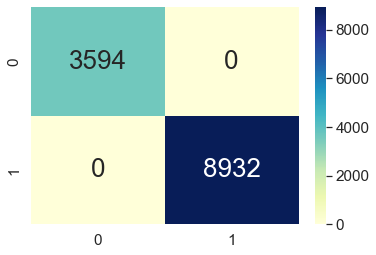

In [75]:
print("Test confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(x_rf_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [115]:
#F1 score

from sklearn.metrics import f1_score
X_test_F1score=f1_score(y_test,rf_predictions_test)
print("Testing F1 score for Random Forest is",X_test_F1score) 

X_train_F1score=f1_score(y_train,rf_predictions_train)
print("Training F1 score for Random Forest is",X_train_F1score) 

Testing F1 score for Random Forest is 1.0
Training F1 score for Random Forest is 0.999972085752568


In [116]:
#Precision
#Testing data
from sklearn.metrics import precision_score
X_rf_prec_test=precision_score(y_test,rf_predictions_test)
print("The precision of Random Forest for testing data",X_rf_prec_test)

#Training data
from sklearn.metrics import precision_score
X_rf_prec_train=precision_score(y_train,rf_predictions_train)
print("The precision of Random Forest for training data",X_rf_prec_train)

The precision of Random Forest for testing data 1.0
The precision of Random Forest for training data 1.0


In [117]:
#Recall
#Testing data
from sklearn.metrics import recall_score
x_rf_rec_test=recall_score(y_test,rf_predictions_test)
print("The recall of test data for Random Forest is:",x_rf_rec_test)

#Training data
from sklearn.metrics import recall_score
x_rf_rec_train=recall_score(y_train,rf_predictions_train)
print("The recall of training data for Random Forest is:",x_rf_rec_train)

The recall of test data for Random Forest is: 1.0
The recall of training data for Random Forest is: 0.9999441730635031


In [118]:
from sklearn.metrics import accuracy_score
a=accuracy_score(y_train,rf_predictions_train)

print("training accuracy for Random Forest is:",a)

from sklearn.metrics import accuracy_score
b=accuracy_score(y_test,rf_predictions_test)

print("testing accuracy for Random Forest is:",b)

training accuracy for Random Forest is: 0.9999600830273032
testing accuracy for Random Forest is: 1.0


# 4. Decision Tree

In [80]:
from sklearn import tree
tuned_parameters=[{'max_depth':[4,5,6]}]

clf = tree.DecisionTreeClassifier(min_samples_split=5,random_state=42)


dt_model=GridSearchCV(clf,tuned_parameters)

dt_model.fit(X_train,y_train)

print(dt_model.best_estimator_)
print("Testing accuracy is: ", dt_model.score(X_test,y_test))
print("Training accuracy is: ",dt_model.score(X_train,y_train))

DecisionTreeClassifier(max_depth=6, min_samples_split=5, random_state=42)
Testing accuracy is:  0.9993613284368513
Training accuracy is:  0.9996008302730321


In [81]:
#predictions
dt_predictions_test=dt_model.predict(X_test)
dt_predictions_train=dt_model.predict(X_train)

In [82]:
# confusion matrix
#training confusion matrix
from sklearn.metrics import confusion_matrix
dt_train=confusion_matrix(y_train,dt_predictions_train)
print(dt_train)

[[14277     2]
 [   18 35807]]


Train confusion matrix


<AxesSubplot:>

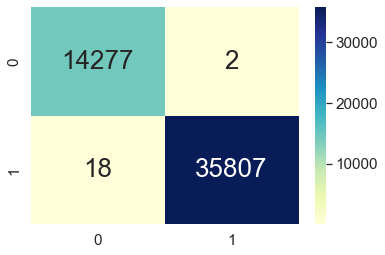

In [83]:
print("Train confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(dt_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [84]:
from sklearn.metrics import confusion_matrix
dt_test=confusion_matrix(y_test,dt_predictions_test)
print(dt_test)

[[3592    2]
 [   6 8926]]


Test confusion matrix


<AxesSubplot:>

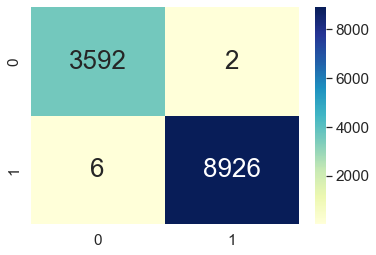

In [85]:
print("Test confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(dt_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [119]:
#F1 score

from sklearn.metrics import f1_score
X_dt_test_F1score=f1_score(y_test,dt_predictions_test)
print("Testing F1 score for Decision Tree is:",X_dt_test_F1score) 

X_dt_train_F1score=f1_score(y_train,dt_predictions_train)
print("Training F1 score for Decision Tree is:",X_dt_train_F1score) 

Testing F1 score for Decision Tree is: 0.9995520716685331
Training F1 score for Decision Tree is: 0.9997208029706564


In [121]:
#Precision
#Testing data
from sklearn.metrics import precision_score
X_dt_prec_test=precision_score(y_test,dt_predictions_test)
print("The precision of Decision Tree for testing data is:",X_dt_prec_test)

#Training data
from sklearn.metrics import precision_score
X_dt_prec_train=precision_score(y_train,dt_predictions_train)
print("The precision of Decision Tree for training data is:",X_dt_prec_train)

The precision of Decision Tree for testing data is: 0.9997759856630825
The precision of Decision Tree for training data is: 0.9999441481191879


In [92]:
#Recall
#Testing data
from sklearn.metrics import recall_score
x_dt_rec_test=recall_score(y_test,dt_predictions_test)
print("The recall of test data for Decision Tree is",x_dt_rec_test)

#Training data
from sklearn.metrics import recall_score
x_dt_rec_train=recall_score(y_train,dt_predictions_train)
print("The recall of training data for Decision Tree is",x_dt_rec_train)

The recall of test data for Decision Tree is 0.9993282579489476
The recall of training data for Decision Tree is 0.9994975575715283


In [122]:
from sklearn.metrics import accuracy_score
a=accuracy_score(y_train,dt_predictions_train)

print("training accuracy for Decision Tree is:",a)

from sklearn.metrics import accuracy_score
b=accuracy_score(y_test,dt_predictions_test)

print("testing accuracy for Decision Tree is:",b)

training accuracy for Decision Tree is: 0.9996008302730321
testing accuracy for Decision Tree is: 0.9993613284368513


# 5. Support Vector Machine (SVM)

In [93]:
from sklearn import svm
tuned_parameters=[{'C':[0.001, 0.01, 0.1, 1, 10]}]
clf= svm.SVC(kernel='rbf')
smodel=GridSearchCV(clf,tuned_parameters,cv=3)

smodel.fit(X_train,y_train)

print(smodel.best_estimator_)
print(smodel.score(X_test,y_test))


SVC(C=10)
1.0


In [96]:
#predictions
svm_predictions_test=smodel.predict(X_test)
svm_predictions_train=smodel.predict(X_train)

In [97]:
# confusion matrix
#training confusion matrix
from sklearn.metrics import confusion_matrix
svm_train=confusion_matrix(y_train,svm_predictions_train)
print(svm_train)

[[14275     4]
 [    4 35821]]


Train confusion matrix


<AxesSubplot:>

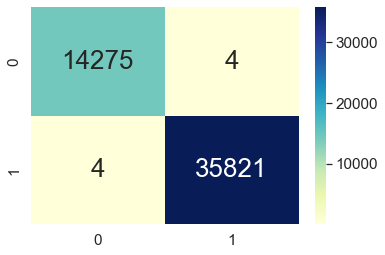

In [98]:
print("Train confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(svm_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [99]:
# confusion matrix
#testing confusion matrix
from sklearn.metrics import confusion_matrix
svm_test=confusion_matrix(y_test,svm_predictions_test)
print(svm_test)

[[3594    0]
 [   0 8932]]


Test confusion matrix


<AxesSubplot:>

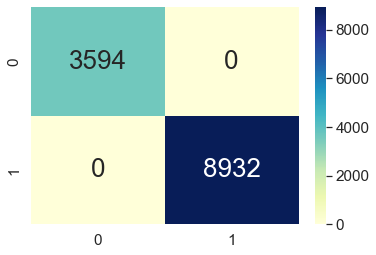

In [100]:
print("Test confusion matrix")
sns.set(font_scale=1.4)
sns.heatmap(svm_test, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

In [123]:
#F1 score

from sklearn.metrics import f1_score
x_svm_test_F1score=f1_score(y_test,svm_predictions_test)
print("Testing F1 score for SVM is:",x_svm_test_F1score) 

x_svm_train_F1score=f1_score(y_train,svm_predictions_train)
print("Training F1 score for SVM is:",x_svm_train_F1score) 

Testing F1 score for SVM is: 1.0
Training F1 score for SVM is: 0.9998883461270063


In [124]:
#Precision
#Testing data
from sklearn.metrics import precision_score
X_svm_prec_test=precision_score(y_test,svm_predictions_test)
print("The precision of SVM for testing data is:",X_dt_prec_test)

#Training data
from sklearn.metrics import precision_score
X_svm_prec_train=precision_score(y_train,svm_predictions_train)
print("The precision of SVM for training data is:",X_svm_prec_train)

The precision of SVM for testing data is: 0.9997759856630825
The precision of SVM for training data is: 0.9998883461270063


In [125]:
#Recall
#Testing data
from sklearn.metrics import recall_score
x_svm_rec_test=recall_score(y_test,svm_predictions_test)
print("The recall of test data for SVM is:",x_svm_rec_test)

#Training data
from sklearn.metrics import recall_score
x_svm_rec_train=recall_score(y_train,svm_predictions_train)
print("The recall of training data for SVM is:",x_svm_rec_train)

The recall of test data for SVM is: 1.0
The recall of training data for SVM is: 0.9998883461270063


In [126]:
from sklearn.metrics import accuracy_score
a=accuracy_score(y_train,svm_predictions_train)

print("training accuracy for SVM is:",a)

from sklearn.metrics import accuracy_score
b=accuracy_score(y_test,svm_predictions_test)

print("testing accuracy for SVM is:",b)

training accuracy for SVM is: 0.9998403321092129
testing accuracy for SVM is: 1.0


# Conclusion

In [106]:
from prettytable import PrettyTable
columns=(["ALGORITHM", "ACCURACY","F1","PRECISION","RECALL"])
myTable = PrettyTable()
myTable.add_column(columns[0], ["KNN","Logistic Regression","SVM", "DECISION TREE" ,"Random Forest"])
myTable.add_column(columns[1], [" 99.93%"," 99.35%","100%", "99.93%", "100%"])
myTable.add_column(columns[2], ["99.97% ","99.54%","100%", "99.95%","100%"])
myTable.add_column(columns[3], ["99.97% ","99.97%","99.97%", "99.97%","100%"])
myTable.add_column(columns[4], ["99.97% ","99.18%","100%", "99.93%","100%"])



print(myTable)

+---------------------+----------+---------+-----------+---------+
|      ALGORITHM      | ACCURACY |    F1   | PRECISION |  RECALL |
+---------------------+----------+---------+-----------+---------+
|         KNN         |  99.93%  | 99.97%  |  99.97%   | 99.97%  |
| Logistic Regression |  99.35%  |  99.54% |   99.97%  |  99.18% |
|         SVM         |   100%   |   100%  |   99.97%  |   100%  |
|    DECISION TREE    |  99.93%  |  99.95% |   99.97%  |  99.93% |
|    Random Forest    |   100%   |   100%  |    100%   |   100%  |
+---------------------+----------+---------+-----------+---------+


This table makes it quite evident that Random Forest has the greatest Accuracy, F1 Score, Precision, and Recall values. Therefore, future production may employ the same ML model.